# Seedtag codetest: NLP Researcher

## Part 1. Classification baseline model

This communication contains a classification baseline model.  However, according to our intelligence department:

- rebels have hacked some texts from one of the categories.

Thus, you should take care of noisy data when improving the baseline model.


In [8]:
import os
import itertools
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# New imports
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity

import spacy
nlp = spacy.load("en_core_web_md")

from sentence_transformers import SentenceTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

Necessary Installations:

! pip install nltk spacy sentence-transformers imbalanced-learn

nltk.download('punkt') 
nltk.download('stopwords')
nltk.download('wordnet') 

!python -m spacy download en_core_web_md

### 0. Auxiliary Functions

In [9]:
def create_df(path, tag):
    '''
    Creates a data frame for a given class
    --------------------------------------
    Input:
        path (str): path where all classes folders are stored.
        tag (str): name of the folder containing class "tag".
    Output:
        df (pd.DataFrame): dataframe with file as index and columns=[text, tag]
    '''
    list_of_text = []
    tag_dir = os.path.join(path, tag)
    for file in os.listdir(tag_dir):

        with open(os.path.join(tag_dir, file), encoding="utf-8", errors="ignore") as f:
            text = f.read()
            list_of_text.append((text, file))
            df = pd.DataFrame(list_of_text, columns = ['Text', 'file'])
            df = df.set_index('file')
    df['tag'] = tag
    return df


def get_all_dfs(path, tags):
    '''
    Loops over all classes in path, each in the corresponding folder
    --------------------------------
    Input:
        path (str): path where all classes folders are stored.
        tags (list): list of classes names.
    Output:
        df (pd.DataFrame): pandas dataframe with the dataframes corresponding to all classes concatenated.
    '''
    list_of_dfs = []
    for tag in tags:

        df = create_df(path, tag)
        list_of_dfs.append(df)
    data = pd.concat(list_of_dfs)
    return data


def tfidf_features(X_train, X_val, X_test, max_features=None):   # This function doesn't take hyperparameters as arguments of the function. No hyperparameter search
    """
        X_train, X_val, X_test — samples
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    tfidf_vectorizer = TfidfVectorizer(
        max_features=max_features,
        min_df=10,
        max_df=0.1,
        ngram_range=(1,1),
        stop_words='english',
        token_pattern=r'([a-zA-Z0-9-/]{2,})')             
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)

    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_


def _score(y_true, y_pred):
    diff = (y_true - y_pred)
    return np.log1p(diff)


def train_clf(X_train, y_train, sol, c, pen):
    """
    X_train, y_train: training data
    c: regularization parameter for LogisticRegression
    pen: penalty for LogisticRegression

    return: trained classifier
    """
    clf = OneVsRestClassifier(
        LogisticRegression(solver=sol, C=c, penalty=pen, class_weight='balanced'),
        n_jobs=-1)
    clf.fit(X_train, y_train)
    return clf

def parameter_search(model, X_train, y_train, X_val, y_val, solver_grid, c_grid, pen_grid, verbose=False):   # Instead of manually iterating over parameters, GridSearchCV automatically optimizes hyperparameters.

    #Avoid Redundant Model Training. You are training the model twice: once inside the loop (gen_classifier = model(...)) and again at the end (train_clf(...)). Instead, store the best model directly
    # Store and Return the Best Hyperparameters and Scores. Add an option to return a dictionary of results for better analysis.
    
    '''
    model: pretrained model
    X_train, y_train: training data
    X_val, y_val: validation data
    c_grid: values for regularization c parameter
    pen_grid: values for penalty parameter
    verbose (bool): whether the score values during hyperparameter tunning are displayed.

    return: best parameters, best classifier
    '''
    ac_scores = []
    scores = []
    grid = [(sol, c, pen) for sol in solver_grid for c in c_grid for pen in pen_grid]
    for sol, c, pen in tqdm(grid):

        gen_classifier = model(X_train, y_train, sol, c, pen)
        y_pred = gen_classifier.predict(X_val)
        ac_score, score = accuracy_score(y_val, y_pred), f1_score(y_val, y_pred, average='weighted')
        if verbose:
            print('For parameters ({}, {:3.2f}, {}), (accuracy, f1_score) are: ({:.6f}, {:.6f})'.format(
                sol, c, pen, ac_score, score))
        ac_scores.append(ac_score)
        scores.append(score)
    best_ind = np.argmax(np.array(scores))
    best_parms = grid[best_ind]
    best_clf = train_clf(X_train, y_train, best_parms[0], best_parms[1], best_parms[2])
    print('Model generated: the best values for the parameters are {}'.format(best_parms))
    return best_clf

def train(dir_name):     # No chance of using some values as inputs. 
    """
    Wrap up function that trains a classification model.
    --------------------------------------------------
    Input:
        dir_name (str): name if the folder containing one subfolder for each class.
    Output:
        model (estimator): LogisticRegression classification model based on OneVsRest approach,
        with a tfidf vector representation for the features.
    """

    tags = os.listdir(path)

    ## data cleaning
    data_full = get_all_dfs(dir_name, tags)
    data_dedup = data_full.drop_duplicates()
    null_texts = data_dedup[data_dedup.Text.duplicated(keep=False)].index
    data = data_dedup.drop(index=null_texts)

    ## text preprocessing
    data_prep = data.copy()

    ## spliting data
    X, X_test, y, y_test = train_test_split(data_prep['Text'], data_prep['tag'], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    ## tfidf_vector representation
    ## features
    X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(
        X_train, X_val, X_test)
    ## labels
    lb = LabelBinarizer()
    y_train_enc = lb.fit_transform(np.transpose([y_train]))
    y_val_enc = lb.transform(y_val)

    ## model training
    SOLVER_GRID = ['liblinear', 'saga']
    C_GRID = [0.01, 0.1, 1, 10, 100, 1000]
    PEN_GRID = ['l1', 'l2']
    print('Training model...')
    model = parameter_search(train_clf, X_train_tfidf, y_train_enc, X_val_tfidf, y_val_enc, SOLVER_GRID, C_GRID, PEN_GRID)
    return model


## Evaluation

def plot_learning_curve(estimator, title, X, y):                 # Evaluate a model's performance and scalability as the size of the training data increases
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features).

    y : array-like, shape (n_samples) or (n_samples, n_features).

    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].set_title(title)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(        # Outputs: train size in every step. Train score in ebvery training size. Fit_times: time to train the model in each training size
        estimator, X, y, cv=5, n_jobs=4, train_sizes=np.linspace(0.1, 1, 6), return_times=True)
    
    # Compute metrics: across 5 folds.
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
    axes[0].plot(train_sizes, train_scores_mean, 'o-', label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt   # Optimized: more arguments in the function. 3 plots into separate helper functions (every olot in a function)->better readability. Seaborn also improves.





def plot_confusion_matrix(            # Could be optimized using seaborn here. Adding color or normalization as arguments for the function.
    cm, classes,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # Normalization: for having sum up to 1.

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

def evaluate_model(model):
    """
    Generates a set of evaluation tools for the model
    Input:
        model (estimator)
    Output:
        None, prints the score for the test set using accuracy and f1_weighted, it also plots the learning
        curve and the confusion matrix.
    """

    lb = LabelBinarizer()
    y_train_enc = lb.fit_transform(np.transpose([y_train]))
    y_test_enc = lb.transform(y_test)

    y_test_predictions = model.predict(X_test_tfidf)
    y_test_pred = lb.inverse_transform(y_test_predictions)
    ac_score, score = accuracy_score(y_test, y_test_pred), f1_score(y_test, y_test_pred, average='weighted')
    print('(accuracy, f1) are: ({:.6f}, {:.6f})'.format(ac_score, score))

    # learning curve
    plot_learning_curve(model, "Learning Curves (LogReg)", X_train_tfidf, y_train_enc)
    plt.show()

    # testing
    print(classification_report(y_test, y_test_pred))
    # Plot non-normalized confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(12,10))
    plot_confusion_matrix(cnf_matrix, classes=lb.classes_, title="Confusion matrix")
    plt.show()

Extra functions needed

In [10]:
# Cleaning function:

def clean_text(text):

    """
    Standarize all the text, leaving it all in the same format. 
    Eliminating all unnecessary metadata ('Article-I.D.:', '===== ... ====='), special characters, exta whitespaces. 
    Then tokenize, to break down the text into smaller components, and then elimante stopwords and lemmatization to leave ony the meaningful
    Input:
        Text column from the dataframe
    Output:
        Finally, 4 columns are created so we can measure performance differences in all of them: the original, without sw, woth sw and lemmatized and without sw and stemmed.
    """

    text = re.sub(r'Article-I\.D\.:.*\n+', '', text)  # Metadata
    text = re.sub(r'===== .* =====', '', text)   # Metadata
    text = re.sub(r'\[.*?\]', '', text)     # Text between square btackets: citations footnotes
    text = re.sub(r'\*.*?\*', '', text)     # Text between asterisks: formatting
    text = text.lower()     # Standarizing text
    text = re.sub(r'[^\w\s]', '', text)     # Special characters and punctuation. Leaves words and spaces
    text = re.sub(r'\s+', ' ', text.strip())  # Extra spaces (caused by previous cleaning steps)
    
    tokens = word_tokenize(text)   # Breaks the text in words, separating by spaces and punctuation
    stop_words = set(stopwords.words('english'))  # Stopwords=out
    tokens_no_stopwords = [word for word in tokens if word not in stop_words]
    
    lemmatizer = WordNetLemmatizer()   # base form. runnning-run
    tokenstfidf_paramsmatized = [lemmatizer.lemmatize(word) for word in tokens_no_stopwords]
    
    stemmer = PorterStemmer()   # root form  arguing-argu
    tokens_stemmed = [stemmer.stem(word) for word in tokens_no_stopwords]
    
    cleaned_text = ' '.join(tokens)
    cleaned_no_stopwords = ' '.join(tokens_no_stopwords)
    cleanedtfidf_paramsmatized = ' '.join(tokenstfidf_paramsmatized)
    cleaned_stemmed = ' '.join(tokens_stemmed)
    
    return cleaned_text, cleaned_no_stopwords, cleanedtfidf_paramsmatized, cleaned_stemmed  # All 4 combinations can be useful


def tfidf_params(X_train, X_val, y_train, y_val, param_grid, verbose=False):  # Iterates through a list of hyperparameters. Simple LogReg model for best hyperparameters finding
    """
    Preprocesses and standardizes text by removing metadata, special characters, and stopwords,
    then generates multiple processed versions with lemmatization and stemming.

    Parameters:
    ----------
    text : str
        Input text string to preprocess.

    Returns:
    -------
    cleaned_text : str
        Cleaned text without additional processing.
    cleaned_no_stopwords : str
        Text without stopwords.
    cleaned_lemmatized : str
        Text lemmatized and without stopwords.
    cleaned_stemmed : str
        Text stemmed and without stopwords.
    """
    best_score = 0
    best_params = None
    best_vectorizer = None

    for params in ParameterGrid(param_grid):
        if verbose:
            print(f"Testing parameters: {params}")

        vectorizer = TfidfVectorizer(**params)
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_val_tfidf = vectorizer.transform(X_val)
        
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train_tfidf, y_train)
        
        score = f1_score(y_val, clf.predict(X_val_tfidf), average='weighted')  

        # Why use "macro" instead of "weighted"?.  For not balanced cases, would be better using macro
        # Macro F1-score calculates the F1-score for each class individually and then takes the unweighted average.
        # Weighted F1-score accounts for class distribution, which is useful for imbalanced datasets, but unnecessary in your case.
        
        if score > best_score:
            best_score = score
            best_params = params
            best_vectorizer = vectorizer

        if verbose:
            print(f"Score for parameters {params}: {score:.4f}")

    X_train_tfidf = best_vectorizer.fit_transform(X_train)
    X_val_tfidf = best_vectorizer.transform(X_val)
    print("Best TF-IDF params:", best_params)
    print("Best F1-Score:", best_score)

    return best_vectorizer, X_train_tfidf, X_val_tfidf, best_params
    

def train_logistic_regression(X_train_tfidf, y_train, param_grid, verbose=1):  # Grid Search. cv=5, for cross validation, make sure model is generalized. 
    # Splitting the dataset multiple times instead of a single train-test split. 
    # No actually validation data, just splitting the training one.
    """
    Train a Logistic Regression model using GridSearchCV with the given TF-IDF parameters.

    Parameters:
    ----------
    X_train_tfidf : sparse matrix
        TF-IDF transformed training data.
    y_train : array-like
        Labels for the training data.
    param_grid : dict
        Parameter grid for Logistic Regression hyperparameter tuning.
    verbose : int, optional (default=1)
        Level of verbosity during GridSearchCV execution.

    Returns:
    --------
    best_model : GridSearchCV
        Fitted GridSearchCV object with the best Logistic Regression model.
    best_params_logreg : dict
        Best parameters for Logistic Regression found during the grid search.
    """
    best_model = GridSearchCV(
        LogisticRegression(max_iter=1000),
        param_grid,
        scoring='f1_weighted',
        cv=5,
        verbose=verbose)

    best_model.fit(X_train_tfidf, y_train)
    best_params_logreg = best_model.best_params_

    if verbose:
        print("Best Logistic Regression Params:", best_params_logreg)

    return best_model, best_params_logreg


def train_random_forest(X_train, y_train, param_grid, verbose=1):    # Actually same function, could have taken both of them together. 
    """
    Train a Random Forest model using GridSearchCV with the given parameter grid.

    Parameters:
    ----------
    X_train : array-like
        Training data (e.g., embeddings).
    y_train : array-like
        Labels for the training data.
    param_grid : dict
        Parameter grid for Random Forest hyperparameter tuning.
    verbose : int, optional (default=1)
        Level of verbosity during GridSearchCV execution.

    Returns:
    --------
    best_model : GridSearchCV
        Fitted GridSearchCV object with the best Random Forest model.
    best_params_rf : dict
        Best parameters for Random Forest found during the grid search.
    """
    best_model = GridSearchCV(
        RandomForestClassifier(),
        param_grid,
        scoring='f1_weighted',
        cv=5,
        verbose=verbose)

    best_model.fit(X_train, y_train)
    best_params_rf = best_model.best_params_

    if verbose:
        print("Best Random Forest Params:", best_params_rf)

    return best_model, best_params_rf



def get_spacy_embeddings(texts):      # 
    """
    Generate embeddings using SpaCy.
    
    Args:
        texts (list of str): Input texts to vectorize.
        
    Returns:
        np.ndarray: Document embeddings for all input texts.
    """
    embeddings = []
    for doc in nlp.pipe(texts, disable=["parser", "ner"]):   # Processes multiple texts in batch mode. Disables unnecessary components (name entity recognition and parser) 
        # Parser: identifies grammatical relationships between words. Compatationally expensive and unnecessary if only extracting embeddings.
        embeddings.append(doc.vector)  
    return np.array(embeddings)


def get_transformer_embeddings(model, texts):   
    """
    Generate embeddings using a SentenceTransformer model.
    
    Args:
        texts (list of str): Input texts to vectorize.
        
    Returns:
        np.ndarray: Document embeddings for all input texts.
    """
    embeddings = model.encode(texts, show_progress_bar=True)   
    return embeddings   # Array where each row is a sentence embedding. 


def evaluate_model_new(X_train_tfidf, y_train, y_test, y_test_pred, best_model):    
    """
    Evaluates the model's performance using predicted and true labels and generates relevant metrics and visualizations.

    Inputs:
        X_train_tfidf (sparse matrix): TF-IDF representation of the training data.
        y_train (array-like): Training labels for the training data.
        y_test (array-like): True labels for the test data.
        y_test_pred (array-like): Predicted labels for the test data.
        best_model (GridSearchCV): Trained GridSearchCV object containing the best model and parameters.

    Outputs:
        None: Prints accuracy, F1-score, classification report, and plots confusion matrix and learning curves.
    """

    ac_score = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    print(f"(accuracy, f1) are: ({ac_score:.6f}, {f1:.6f})")
    print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

    cnf_matrix = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(10, 7))
    plot_confusion_matrix(cnf_matrix, classes=np.unique(y_test), title="Confusion Matrix")
    plt.show()
    
    plot_learning_curve(best_model.best_estimator_, "Learning Curves", X_train_tfidf, y_train)
    plt.show()



def evaluate_model_smote(X_train_resampled, y_train_resampled, best_params, y_test, y_test_pred, best_model): 
    """
    Evaluates the model's performance using predicted and true labels and generates relevant metrics and visualizations.

    Inputs:
        X_train_tfidf (sparse matrix): TF-IDF representation of the training data.
        y_train (array-like): Training labels for the training data.
        y_test (array-like): True labels for the test data.
        y_test_pred (array-like): Predicted labels for the test data.
        best_model (GridSearchCV): Trained GridSearchCV object containing the best model and parameters.

    Outputs:
        None: Prints accuracy, F1-score, classification report, and plots confusion matrix and learning curves.
    """

    ac_score = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    print(f"(accuracy, f1) are: ({ac_score:.6f}, {f1:.6f})")
    print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

    cnf_matrix = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(10, 7))
    plot_confusion_matrix(cnf_matrix, classes=np.unique(y_test), title="Confusion Matrix")
    plt.show()
    
    final_model = LogisticRegression(
        solver=best_params['logreg__solver'],
        C=best_params['logreg__C'],
        penalty=best_params['logreg__penalty'],
        class_weight=best_params['logreg__class_weight'],
        max_iter=100)
    final_model.fit(X_train_resampled, y_train_resampled)

    plot_learning_curve(final_model, "Learning Curves", X_train_resampled, y_train_resampled)
    plt.show()



def train_logistic_regression_with_smote(X_train, y_train, param_grid, smote_grid, verbose=1):
    """
    Train a Logistic Regression model using GridSearchCV with integrated SMOTE.

    Parameters:
    ----------
    X_train : sparse matrix
        Training data.
    y_train : array-like
        Labels for the training data.
    param_grid : dict
        Parameter grid for Logistic Regression hyperparameter tuning.
    smote_grid : dict
        Grid for SMOTE sampling strategies.
    verbose : int, optional (default=1)
        Level of verbosity during GridSearchCV execution.

    Returns:
    --------
    best_model : GridSearchCV
        Fitted GridSearchCV object with the best Logistic Regression model.
    best_params : dict
        Best parameters found during the grid search, including SMOTE settings.
    X_train_resampled : array-like
        Resampled training data after applying SMOTE.
    y_train_resampled : array-like
        Resampled training labels after applying SMOTE.
    """
    X_train_resampled, y_train_resampled = None, None

    pipeline = Pipeline([('smote', SMOTE(random_state=42, k_neighbors=2)),  ('logreg', LogisticRegression(max_iter=1000))])
    
    combined_param_grid = {
        'smote__sampling_strategy': smote_grid['sampling_strategy'],
        'logreg__solver': param_grid['solver'],
        'logreg__C': param_grid['C'],
        'logreg__penalty': param_grid['penalty'],
        'logreg__class_weight': param_grid['class_weight'],}
    
    best_model = GridSearchCV(
        pipeline,
        combined_param_grid,
        scoring='f1_weighted',
        cv=5,
        verbose=verbose)
    
    best_model.fit(X_train, y_train)
    best_params = best_model.best_params_

    smote_step = best_model.best_estimator_.named_steps['smote']
    X_train_resampled, y_train_resampled = smote_step.fit_resample(X_train, y_train)
    if verbose:
        print("Best Parameters (with SMOTE):", best_params)
        print("Resampled Training Data Shape:", X_train_resampled.shape)
        print("Resampled Training Labels Distribution:", Counter(y_train_resampled))

    return best_model, best_params, X_train_resampled, y_train_resampled

### 1. Loading data

In [11]:
path = '../part1/dataset'
tags = os.listdir(path)
tags

['exploration',
 'headhunters',
 'intelligence',
 'logistics',
 'politics',
 'transportation',
 'weapons']

In [12]:
data_full = get_all_dfs(path, tags)
print(data_full.shape)
data_full.tail()

(3853, 2)


,Text,tag
file,,
55246,\nAs quoted from <1993Apr17.025258.7013@micros...,weapons
55247,\nIn article <2071@rwing.UUCP> pat@rwing.UUCP ...,weapons
55473,07:24:55 GMT\n <1qjmnuINNlmd@cl...,weapons
55474,\nAs quoted from <1993Apr18.000152.2339@gnv.if...,weapons
55475,\nPoliticians want to eliminate private owners...,weapons


In [13]:
data_full.columns

Index(['Text', 'tag'], dtype='object')

In [14]:
data_dedup = data_full.drop_duplicates()
null_texts = data_dedup[data_dedup.Text.duplicated(keep=False)].index
data = data_dedup.drop(index=null_texts)

tag
politics          604
transportation    593
exploration       586
headhunters       583
weapons           546
logistics         469
intelligence      453
Name: count, dtype: int64


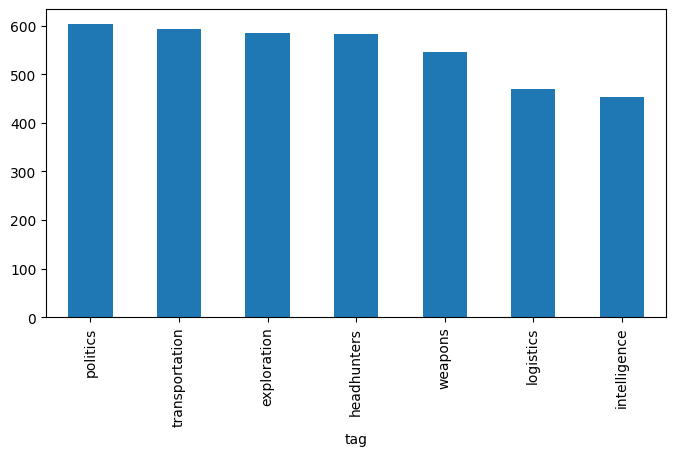

In [15]:
print(data['tag'].value_counts())
plt.figure(figsize=(8,4))
data['tag'].value_counts().plot(kind='bar');

#### 1.2 Extra cleaning process

The texts are quite chaotic and really long. They talk basicly about space exploration, some containing a lot of dense, domain-specific information and some just provide personal comentaries about it. 

They contain many special characters that can be cleaned, like some metadata information (headers, contact details). This function cleans and standarizes the text, but many of them still contain a lot of noise information.

It is important to eliminate stopwords and lemmatize to reduce the length of the TF-IDF dictionaries and have only the most useful information

In [16]:
data['Text'].iloc[2]

'Article-I.D.: cs.astronaut_733694515\n\n\nHOW TO BECOME AN ASTRONAUT\n\n    First the short form, authored by Henry Spencer, then an official NASA\n    announcement.\n\n    Q. How do I become an astronaut?\n\n    A. We will assume you mean a NASA astronaut, since it\'s probably\n    impossible for a non-Russian to get into the cosmonaut corps (paying\n    passengers are not professional cosmonauts), and the other nations have\n    so few astronauts (and fly even fewer) that you\'re better off hoping to\n    win a lottery. Becoming a shuttle pilot requires lots of fast-jet\n    experience, which means a military flying career; forget that unless you\n    want to do it anyway. So you want to become a shuttle "mission\n    specialist".\n\n    If you aren\'t a US citizen, become one; that is a must.  After that,\n    the crucial thing to remember is that the demand for such jobs vastly\n    exceeds the supply.  NASA\'s problem is not finding qualified people,\n    but thinning the lineup 

In [17]:
data_clean=data.copy()      # Copy for new columns creation

We leave 4 different combinations, because depending on the model selected some of them can be useful.

In [18]:
data_clean[['cleaned_text', 'no_stopwords', 'lemmatized', 'stemmed']] = data_clean['Text'].apply(lambda x: pd.Series(clean_text(x)))
data_clean.head(2)

,Text,tag,cleaned_text,no_stopwords,lemmatized,stemmed
file,,,,,,
59848,Article-I.D.: cs.controversy_733694426\n\n\nCO...,exploration,controversial questions these issues periodica...,controversial questions issues periodically co...,controversial question issue periodically come...,controversi question issu period come much arg...
59849,Article-I.D.: cs.groups_733694492\n\n\nSPACE A...,exploration,space activistinterestresearch groups and spac...,space activistinterestresearch groups space pu...,space activistinterestresearch group space pub...,space activistinterestresearch group space pub...


All texts are really large and extra cleaning would require more information about specific kind of data that wants to be elimanted.

In [19]:
data_clean['word_count'] = data_clean['lemmatized'].apply(lambda x: len(x.split()))
data_clean['word_count'].describe()

count     3834.000000
mean       169.505477
std        448.433096
min          0.000000
25%         49.000000
50%         88.000000
75%        154.000000
max      15510.000000
Name: word_count, dtype: float64

In [20]:
data_prep=data.copy()

### 2. Features representation

In [21]:
X, X_test, y, y_test = train_test_split(data_prep['Text'], data_prep['tag'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

### 3. Training

In [358]:
classifier_tfidf = train('../part1/dataset')

Training model...


100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


Model generated: the best values for the parameters are ('saga', 1000, 'l1')


### 4. Evaluation

(accuracy, f1) are: (0.887875, 0.890601)


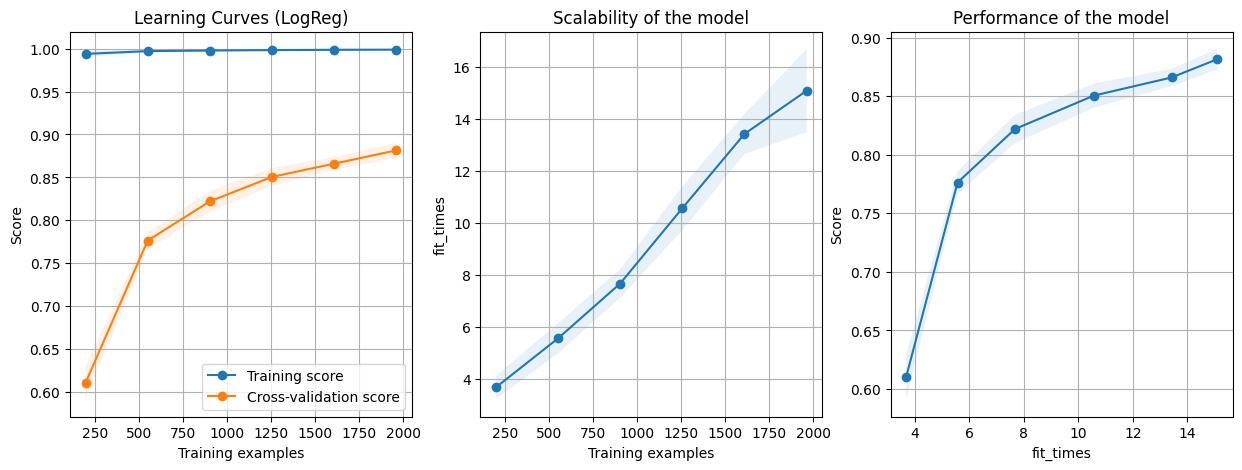

                precision    recall  f1-score   support

   exploration       0.71      0.96      0.81       140
   headhunters       0.91      0.93      0.92       107
  intelligence       0.96      0.79      0.87        95
     logistics       0.97      0.87      0.92        82
      politics       0.93      0.91      0.92       125
transportation       0.96      0.88      0.92       113
       weapons       0.97      0.84      0.90       105

      accuracy                           0.89       767
     macro avg       0.92      0.88      0.89       767
  weighted avg       0.90      0.89      0.89       767



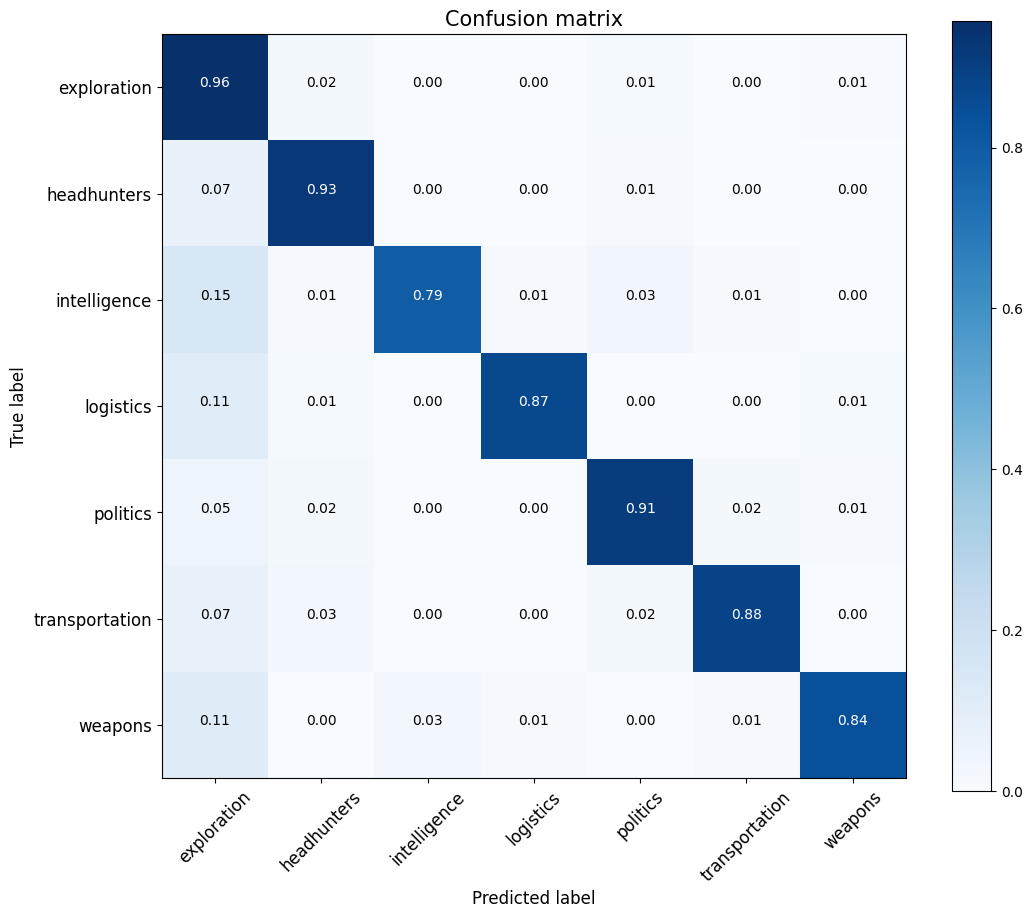

In [359]:
evaluate_model(classifier_tfidf)

###

#### Conclusions:

Performance is not bad (f1-score=0.89), with the initial approach based on vectorizing with TF-IDF and classificating with Logistic Regression model.

I will do various iterations with different approaches to try to improve model's performance as much as possible.

### 5. Cleaned data

Let's try and see if performance can be improved just by using the new text we have cleaned

In [27]:
X_clean, X_test_clean, y_clean, y_test_clean = train_test_split(data_clean['lemmatized'], data_clean['tag'], test_size=0.2, random_state=42)
X_train_clean, X_val_clean, y_train_clean, y_val_clean = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

In [28]:
X_train_tfidf_clean, X_val_tfidf_clean, X_test_tfidf_clean, tfidf_vocab_clean,  = tfidf_features(X_train_clean, X_val_clean, X_test_clean)
tfidf_reversed_vocab_clean = {i: word for word, i in tfidf_vocab_clean.items()}

Train and test this model, just using different data but the same approach. Functions cannot be reused, they don't take new data as arguments.

In [362]:
lb_clean = LabelBinarizer()
y_train_enc_clean = lb_clean.fit_transform(y_train_clean)
y_val_enc_clean = lb_clean.transform(y_val_clean)
SOLVER_GRID = ['liblinear', 'saga']
C_GRID = [0.01, 0.1, 1, 10, 100, 1000]
PEN_GRID = ['l1', 'l2']
print('Training model...')
model_clean = parameter_search(train_clf, X_train_tfidf_clean, y_train_enc_clean, X_val_tfidf_clean, y_val_enc_clean, SOLVER_GRID, C_GRID, PEN_GRID)

y_test_enc_clean = lb_clean.transform(y_test_clean)
y_test_predictions = model_clean.predict(X_test_tfidf_clean)
y_test_pred = lb_clean.inverse_transform(y_test_predictions)
ac_score, score = accuracy_score(y_test, y_test_pred), f1_score(y_test, y_test_pred, average='weighted')
print('(accuracy, f1) are: ({:.6f}, {:.6f})'.format(ac_score, score))
print("\nClassification Report:\n")
print(classification_report(y_test_clean, y_test_pred))

Training model...


  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


Model generated: the best values for the parameters are ('saga', 10, 'l2')
(accuracy, f1) are: (0.864407, 0.868817)

Classification Report:

                precision    recall  f1-score   support

   exploration       0.65      0.96      0.77       140
   headhunters       0.93      0.90      0.91       107
  intelligence       0.93      0.74      0.82        95
     logistics       0.96      0.84      0.90        82
      politics       0.96      0.90      0.93       125
transportation       0.95      0.86      0.90       113
       weapons       0.94      0.79      0.86       105

      accuracy                           0.86       767
     macro avg       0.90      0.86      0.87       767
  weighted avg       0.89      0.86      0.87       767



#### Conclusion: 

Using more cleaned data doesn't really improves the performance, but there is still room for improvement with other approaches

### 6) Tuning TFIDF hyperparameters

Introducing Grid Search for the TFIDF as well and then optimize the hyperparameter seach for the model.

The function parameter_search looks for best hyperparameters manually, instead of that GridSearchCV allows a cleaner and more efficient hyperparameter tuning

In [363]:
# Define the parameter grid
tfidf_grid={'max_features': [5000, 10000, 20000], 'min_df': [5, 10, 20], 'max_df': [0.5, 0.7, 1.0], 'ngram_range': [(1, 1), (1, 2)]}
# max_features: limits the number of features (words/tokens) to include in the TFIDF. Only this top words
# min_df: minimum document frequency. Less than 5, 10 documents.
# max_df: eliminates too many common words. Percentage, stopwords.
# n_gram: bigrams (pair of consecutive words). New York is treated as one. Bigrams and unigrams are taken into the vocabulary. 

best_vectorizer, X_train_tfidf, X_val_tfidf, best_params = tfidf_params(X_train_clean, X_val_clean, y_train_clean, y_val_clean, tfidf_grid)

Best TF-IDF params: {'max_df': 0.7, 'max_features': 10000, 'min_df': 5, 'ngram_range': (1, 2)}
Best F1-Score: 0.9303439722359967


In [364]:
model_grid = {'solver': ['liblinear', 'saga'], 'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}
best_model, best_params_logreg = train_logistic_regression(X_train_tfidf, y_train_clean, model_grid)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Logistic Regression Params: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}


(accuracy, f1) are: (0.917862, 0.917933)

Classification Report:
                 precision    recall  f1-score   support

   exploration       0.94      0.91      0.93       140
   headhunters       0.85      0.96      0.90       107
  intelligence       0.92      0.86      0.89        95
     logistics       0.95      0.90      0.93        82
      politics       0.94      0.94      0.94       125
transportation       0.91      0.91      0.91       113
       weapons       0.92      0.92      0.92       105

      accuracy                           0.92       767
     macro avg       0.92      0.92      0.92       767
  weighted avg       0.92      0.92      0.92       767



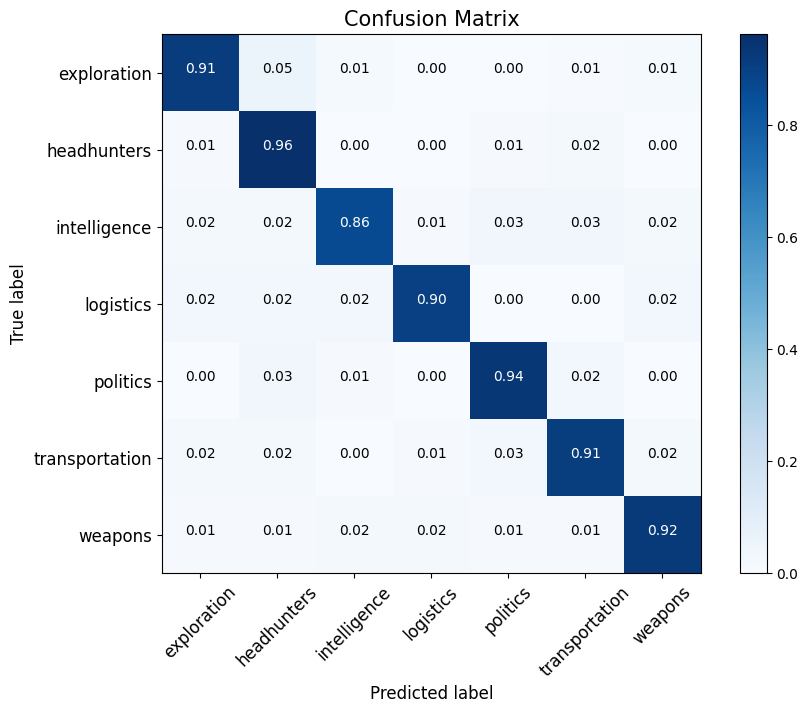

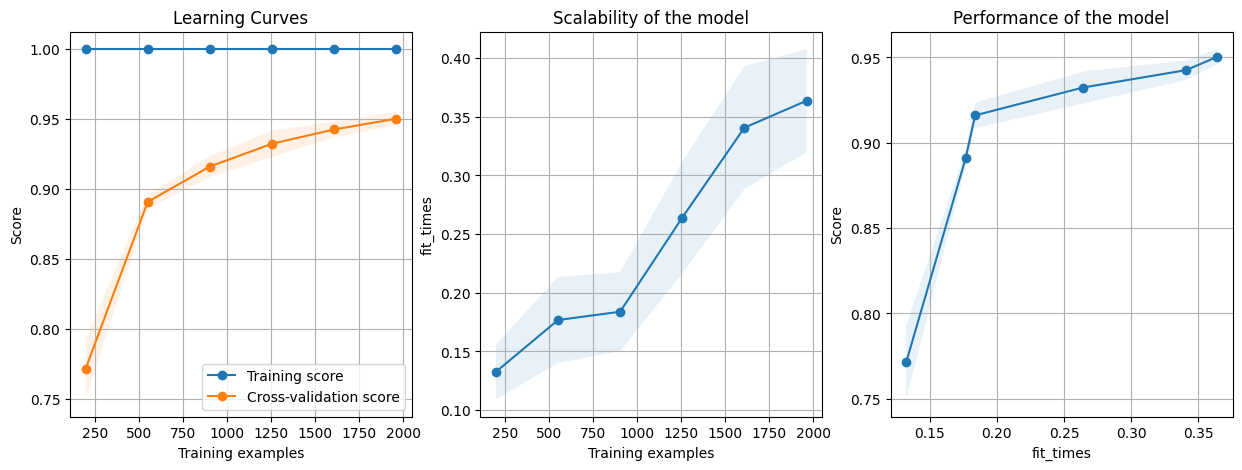

In [365]:
X_test_tfidf = best_vectorizer.transform(X_test_clean)
y_test_pred = best_model.predict(X_test_tfidf)
evaluate_model_new(X_train_tfidf, y_train_clean, y_test_clean, y_test_pred, best_model)

#### Conclusion:

Tuning hyperparameters for TF-IDF improves performance by 4%

#### Extra Analysis

Calculate the maximum probability the model is assigning to every category helps to evaluate how sure the model is of the decisions it is taking.

In [366]:
X_test_tfidf = best_vectorizer.transform(X_test_clean)
y_test_proba = best_model.predict_proba(X_test_tfidf)
y_test_pred = best_model.predict(X_test_tfidf)
max_probabilities_test = y_test_proba.max(axis=1)

test_results = pd.DataFrame({
    'Text': X_test_clean, 
    'Predicted_Category': y_test_pred,
    'Max_Probability': max_probabilities_test,
    'Real_Values': y_test_clean})

test_results.head()

,Text,Predicted_Category,Max_Probability,Real_Values
file,,,,
102744,howdy im little new newsgroup would like tap k...,transportation,0.953243,transportation
104609,went dodger game tonight cap night astacio pit...,politics,0.989559,politics
38391,howdy wondering people could email opinion var...,headhunters,0.989180,headhunters
102959,morning 88 ford ranger idling 10000 rpm ok exa...,transportation,0.864169,transportation
51245,114127buedu jaegerbuphybuedu writes dont under...,logistics,0.988025,logistics


In [367]:
test_results.Max_Probability.describe()

count    767.000000
mean       0.791540
std        0.219663
min        0.182442
25%        0.674392
50%        0.887308
75%        0.961788
max        0.999975
Name: Max_Probability, dtype: float64

In [368]:
# Probabilities by category
mean_probabilities = test_results.groupby('Predicted_Category')['Max_Probability'].mean().reset_index()
print(mean_probabilities)

  Predicted_Category  Max_Probability
0        exploration         0.814833
1        headhunters         0.772075
2       intelligence         0.733648
3          logistics         0.797890
4           politics         0.821320
5     transportation         0.787860
6            weapons         0.796664


Flagging cases for manual review where the probability falls below a threshold set by stakeholders can be an effective strategy to manage uncertain classifications. Additionally, these cases could be assigned to a new category labeled "Undefined" to indicate the need for further evaluation. 

We can also plot the most important terms for each category and review them with stakeholders to see if they match their expectations.

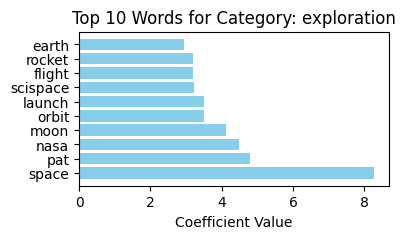

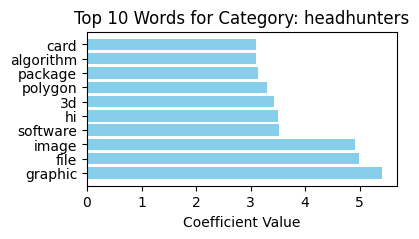

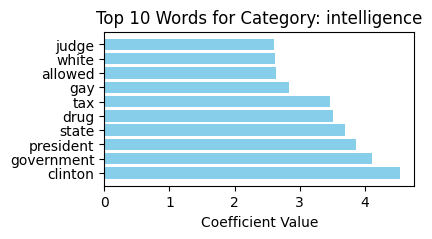

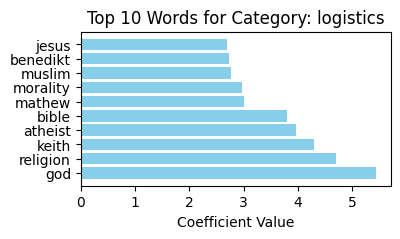

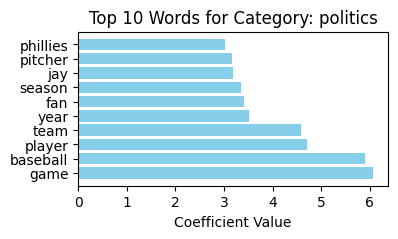

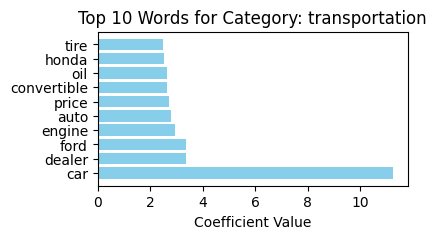

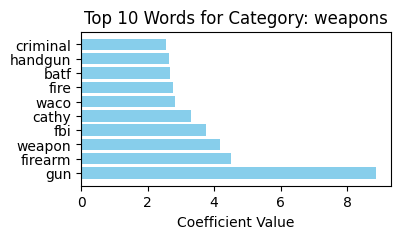

In [369]:
vectorizer = best_vectorizer   
log_reg = best_model.best_estimator_

feature_names = np.array(vectorizer.get_feature_names_out())   # Extract all words that were used in TF-IDF transformation. Each feature is an specific word or n-gram
coefficients = log_reg.coef_    # Each row is a class. Each column is a feature. coefficients[i][j]: the importance(weight) of word j for class i.

# Top 10 words
for i, category in enumerate(log_reg.classes_):
    sorted_indices = coefficients[i].argsort() 
    top_words = feature_names[sorted_indices[-10:]]
    top_coeffs = coefficients[i][sorted_indices[-10:]]
    
    # Plotting
    plt.figure(figsize=(4, 2))
    plt.barh(top_words, top_coeffs, color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top 10 Words for Category: {category}')
    plt.gca().invert_yaxis() 
    plt.show()


### 7) Using Embeddings for vectorization 

This vectorization captures the semantic relationships between words and they consider the context in which a word appears. They can be more efficient in more complex tasks but it depends on the kind of data we are dealing with.

#### 7.1) Using Spacy models

In [29]:
# Generate embeddings
X_train_spacy = get_spacy_embeddings(X_train_clean)
X_val_spacy = get_spacy_embeddings(X_val_clean)
X_test_spacy = get_spacy_embeddings(X_test_clean)

In [30]:
model_grid_spacy = {'solver': ['liblinear', 'saga'], 'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}
best_model_spacy, best_params_logreg_spacy = train_logistic_regression(X_train_spacy, y_train_clean, model_grid_spacy)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Logistic Regression Params: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


(accuracy, f1) are: (0.829205, 0.829233)

Classification Report:
                 precision    recall  f1-score   support

   exploration       0.83      0.84      0.83       140
   headhunters       0.86      0.89      0.88       107
  intelligence       0.75      0.74      0.74        95
     logistics       0.81      0.87      0.84        82
      politics       0.91      0.85      0.88       125
transportation       0.82      0.82      0.82       113
       weapons       0.81      0.79      0.80       105

      accuracy                           0.83       767
     macro avg       0.83      0.83      0.83       767
  weighted avg       0.83      0.83      0.83       767



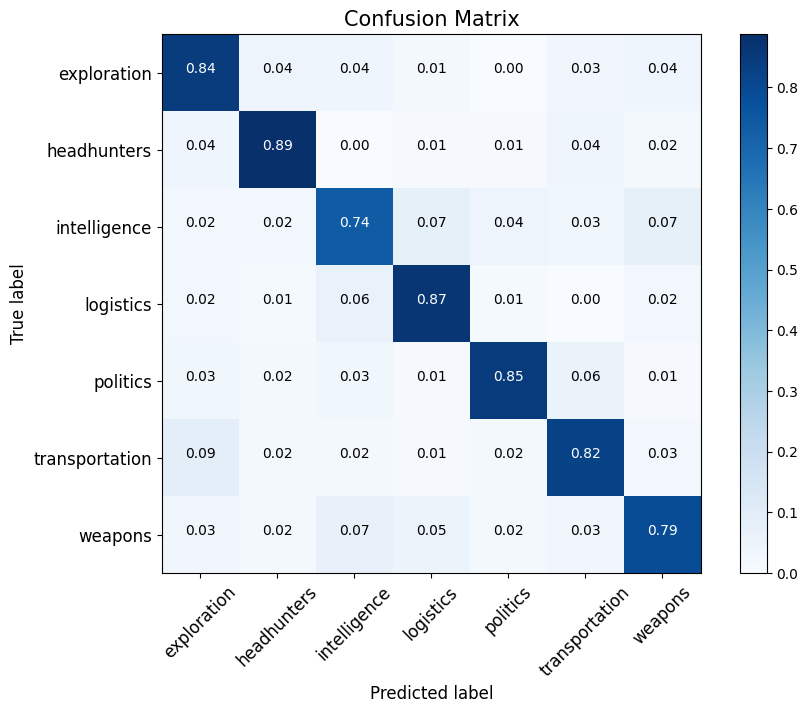

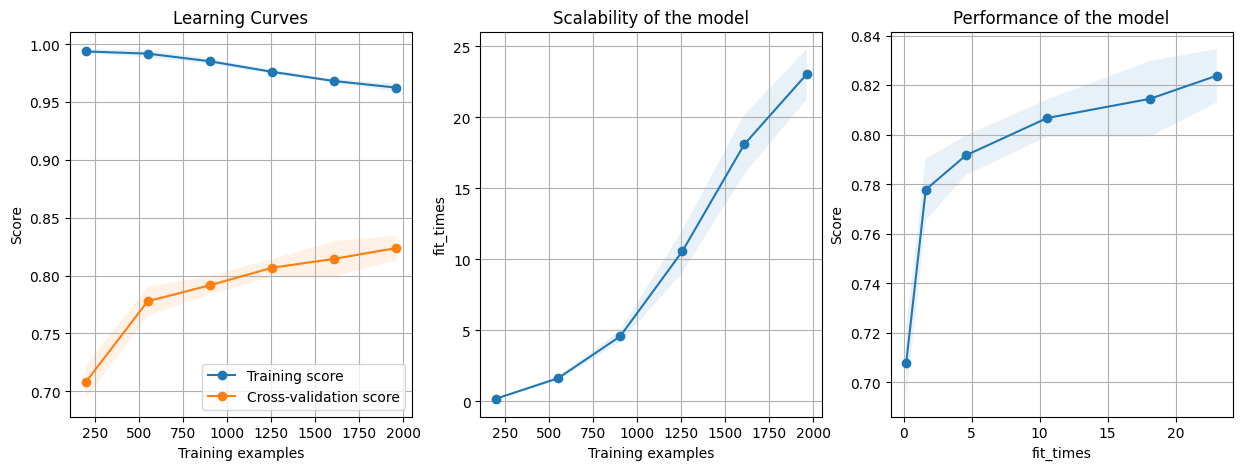

In [31]:
y_test_pred_spacy = best_model_spacy.predict(X_test_spacy)
evaluate_model_new(X_train_spacy, y_train_clean, y_test_clean, y_test_pred_spacy, best_model_spacy)

#### Conclusions:

Spacy embeddings uses static word embedding so it doesn't take into account the relationships between words, so they are not so strong when identifying the context of the sentences. 

Embeddings from Transformer's models based on the context might improve the performance.

#### 7.2) Using Transformers model

Using Logistic Regression for classification

In [32]:
model_transformer = SentenceTransformer('all-MiniLM-L6-v2')

In [33]:
X_train_transformer = get_transformer_embeddings(model_transformer, X_train_clean)
X_val_transformer = get_transformer_embeddings(model_transformer, X_val_clean)
X_test_transformer = get_transformer_embeddings(model_transformer, X_test_clean)

Batches: 100%|██████████| 24/24 [00:40<00:00,  1.70s/it]


In [375]:
model_grid_transformer = {'solver': ['liblinear', 'saga'], 'C': [0.01, 1, 10], 'penalty': ['l1', 'l2']}
best_model_transformer, best_params_logreg_transformer = train_logistic_regression(X_train_transformer, y_train_clean, model_grid_transformer)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Logistic Regression Params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


(accuracy, f1) are: (0.893090, 0.892695)

Classification Report:
                 precision    recall  f1-score   support

   exploration       0.91      0.90      0.91       140
   headhunters       0.86      0.94      0.90       107
  intelligence       0.82      0.78      0.80        95
     logistics       0.88      0.83      0.86        82
      politics       0.96      0.94      0.95       125
transportation       0.91      0.93      0.92       113
       weapons       0.88      0.89      0.88       105

      accuracy                           0.89       767
     macro avg       0.89      0.89      0.89       767
  weighted avg       0.89      0.89      0.89       767



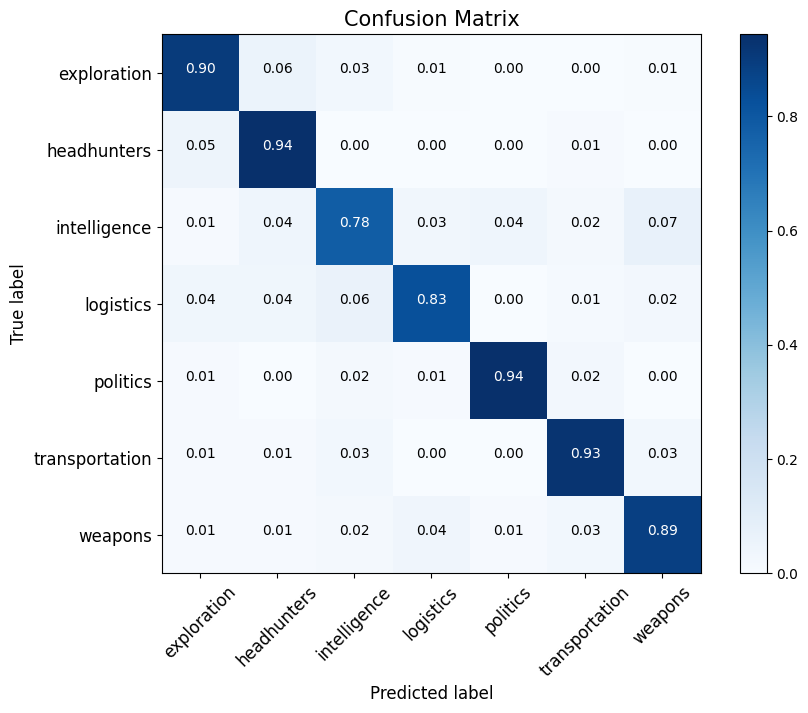

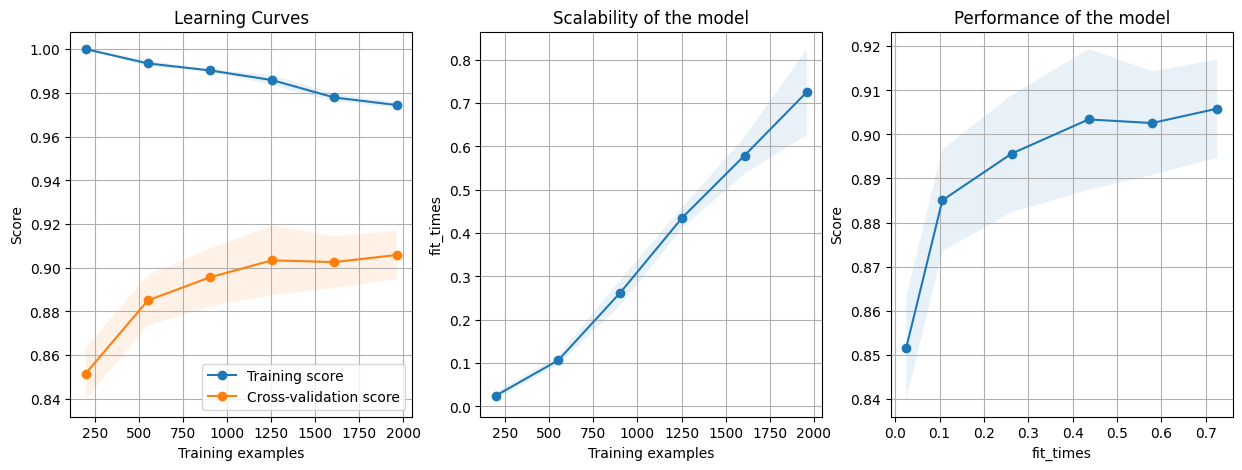

In [376]:
y_test_pred_transformer = best_model_transformer.predict(X_test_transformer)
evaluate_model_new(X_train_transformer, y_train_clean, y_test_clean, y_test_pred_transformer, best_model_transformer)

In [377]:
data_clean.head(2)

,Text,tag,cleaned_text,no_stopwords,lemmatized,stemmed,word_count
file,,,,,,,
59848,Article-I.D.: cs.controversy_733694426\n\n\nCO...,exploration,controversial questions these issues periodica...,controversial questions issues periodically co...,controversial question issue periodically come...,controversi question issu period come much arg...,1114
59849,Article-I.D.: cs.groups_733694492\n\n\nSPACE A...,exploration,space activistinterestresearch groups and spac...,space activistinterestresearch groups space pu...,space activistinterestresearch group space pub...,space activistinterestresearch group space pub...,1312


### Training with column 'cleaned_text' instead of 'lemmatized', with just the cleaned text nut without lemmatization or eliminating stopwords

In [24]:
X_clean_all, X_test_clean_all, y_clean_all, y_test_clean_all = train_test_split(data_clean['cleaned_text'], data_clean['tag'], test_size=0.2, random_state=42)
X_train_clean_all, X_val_clean_all, y_train_clean_all, y_val_clean_all = train_test_split(X_clean_all, y_clean_all, test_size=0.2, random_state=42)

In [25]:
X_train_transformer_all = get_transformer_embeddings(model_transformer, X_train_clean_all)
X_val_transformer_all = get_transformer_embeddings(model_transformer, X_val_clean_all)
X_test_transformer_all = get_transformer_embeddings(model_transformer, X_test_clean_all)

NameError: name 'model_transformer' is not defined

In [380]:
model_grid_transformer_all = {'solver': ['liblinear', 'saga'], 'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}
best_model_transformer_all, best_params_logreg_transformer_all = train_logistic_regression(X_train_transformer_all, y_train_clean_all, model_grid_transformer_all)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Logistic Regression Params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


(accuracy, f1) are: (0.903520, 0.903248)

Classification Report:
                 precision    recall  f1-score   support

   exploration       0.93      0.91      0.92       140
   headhunters       0.93      0.97      0.95       107
  intelligence       0.82      0.76      0.79        95
     logistics       0.84      0.87      0.85        82
      politics       0.98      0.95      0.96       125
transportation       0.94      0.93      0.93       113
       weapons       0.85      0.90      0.87       105

      accuracy                           0.90       767
     macro avg       0.90      0.90      0.90       767
  weighted avg       0.90      0.90      0.90       767



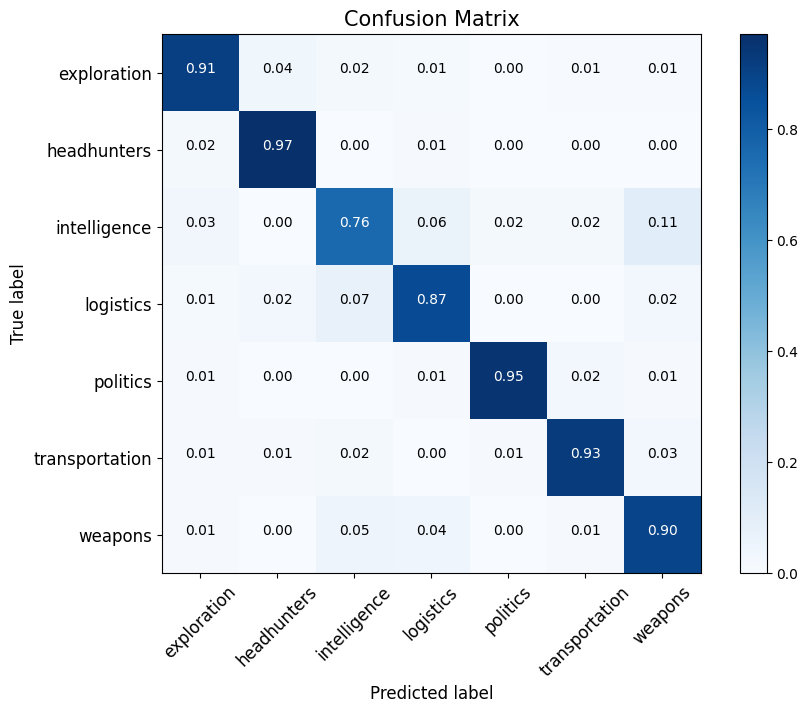

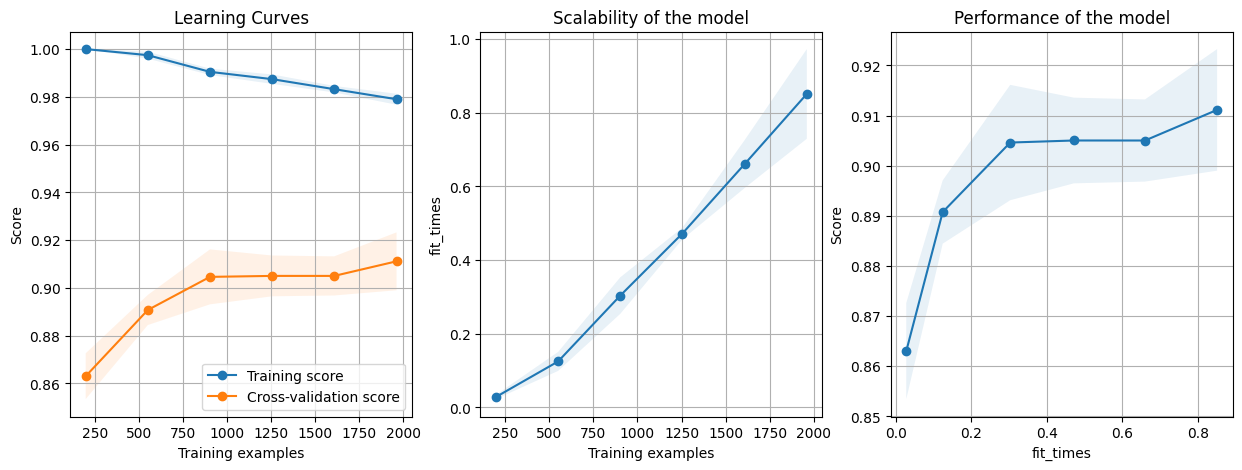

In [381]:
y_test_pred_transformer_all = best_model_transformer_all.predict(X_test_transformer_all)
evaluate_model_new(X_train_transformer_all, y_train_clean_all, y_test_clean_all, y_test_pred_transformer_all, best_model_transformer_all)

#### Conclusions:

The dataset is full of technical and domain-specific text with a lot of detail and nois. The LLM may struggle to give importance to important terms that are critical for classification.

Having so long texts might provoque the important phrases to be covered by less relevant content. 

all-MiniLM-L6-v2 has been trained for general text data, some specific vocabulary might not be inside its pretraining corpus.

Training with clean data without eliminating stopwords and lemmatize improves slightlz the performance as the model is capable of reallz understanding the meaning of the sentences.

#### 7.3) Using Transformers model

Using Random Forest for classification

In [382]:
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, None], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}
best_model_rf, best_params_rf = train_random_forest(X_train_transformer, y_train_clean, param_grid_rf)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Random Forest Params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


(accuracy, f1) are: (0.855280, 0.855782)

Classification Report:
                 precision    recall  f1-score   support

   exploration       0.78      0.88      0.83       140
   headhunters       0.84      0.88      0.86       107
  intelligence       0.79      0.77      0.78        95
     logistics       0.86      0.82      0.84        82
      politics       0.96      0.92      0.94       125
transportation       0.91      0.86      0.88       113
       weapons       0.87      0.83      0.85       105

      accuracy                           0.86       767
     macro avg       0.86      0.85      0.85       767
  weighted avg       0.86      0.86      0.86       767



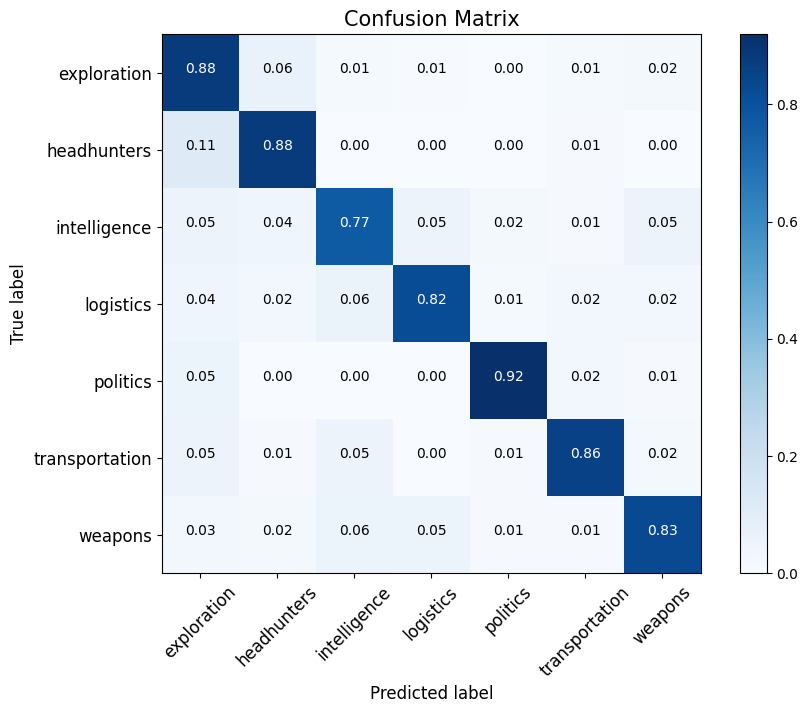

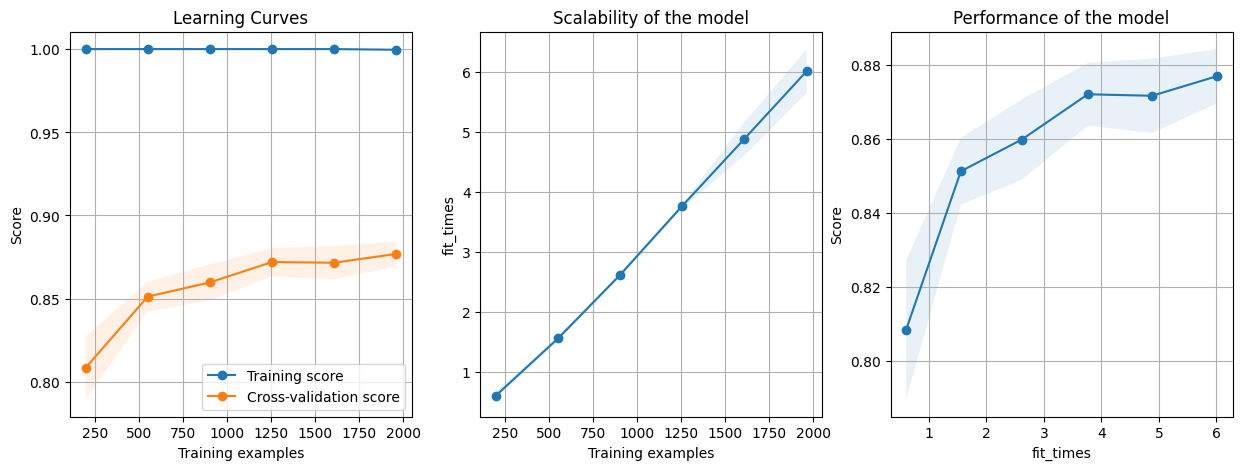

In [383]:
y_test_pred_rf = best_model_rf.predict(X_test_transformer)
evaluate_model_new(X_train_transformer, y_train_clean, y_test_clean, y_test_pred_rf, best_model_rf)

Random Forest struggles with the dense and noisy nature of the embeddings. It is a tree-based model so it splits into thresholds, this is less ideal for embeddings because it might not capture all the relationships between dimensions.

On the other part, Logistic Regression, as a linear model works better with structured and continuous data.

** Fine-tuning a large language model (LLM) using the training data, including all texts and their corresponding categories, could yield the most accurate and powerful results. However, this approach entails significant computational and financial costs.

** The intelligence class has always worst results than the others, maybe the data there should be reviewed

## 

### 8) PART 2. NEW CATEGORY

In [384]:
path_new = '../part2/dataset'
tags_new = os.listdir(path_new)
tags_new

['elite']

In [385]:
data_new = get_all_dfs(path_new, tags_new)
print(data_new.shape)
data_new.tail()

(10, 2)


,Text,tag
file,,
214799,oscar snubs: critics' favourite myth – until ...,elite
231166,the olsen twins mary kate and ashley spill the...,elite
237803,good morning britain host kate garraway in tal...,elite
36076,James Jordan’s takes ANOTHER pop at Celebrity ...,elite
66785,kate middletons new private secretary catherin...,elite


Apply the same cleaning

In [386]:
data_new[['cleaned_text', 'no_stopwords', 'lemmatized', 'stemmed']] = data_new['Text'].apply(lambda x: pd.Series(clean_text(x)))
data_new['word_count'] = data_new['lemmatized'].apply(lambda x: len(x.split()))

In [387]:
data_new['word_count'].describe()

count     10.000000
mean     172.800000
std      128.861511
min       26.000000
25%       80.500000
50%      167.000000
75%      199.000000
max      481.000000
Name: word_count, dtype: float64

In [388]:
data_new.shape

(10, 7)

Join both dataframes

In [389]:
data_new_final=pd.concat([data_new, data_clean])

Let's run the model once and see how this category might perform and also affect the other ones

In [392]:
X_new_tfidf_params, X_new_test_tfidf_params, y_new_tfidf_params, y_new_test_tfidf_params = train_test_split(data_new_final['lemmatized'], data_new_final['tag'], test_size=0.2, random_state=42)
X_new_train_tfidf_params, X_new_val_tfidf_params, y_new_train_tfidf_params, y_new_val_tfidf_params = train_test_split(X_new_tfidf_params, y_new_tfidf_params, test_size=0.2, random_state=42)

Best TF-IDF params: {'max_df': 0.5, 'max_features': 10000, 'min_df': 5, 'ngram_range': (1, 2)}
Best F1-Score: 0.9373649304967752
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Logistic Regression Params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
(accuracy, f1) are: (0.936281, 0.935523)

Classification Report:
                 precision    recall  f1-score   support

         elite       0.00      0.00      0.00         1
   exploration       0.98      0.90      0.94       140
   headhunters       0.86      0.98      0.91       109
  intelligence       0.96      0.85      0.90        92
     logistics       0.96      0.96      0.96        96
      politics       0.94      0.99      0.96       124
transportation       0.93      0.95      0.94       112
       weapons       0.95      0.93      0.94        95

      accuracy                           0.94       769
     macro avg       0.82      0.82      0.82       769
  weighted avg       0.94      0.94      0.

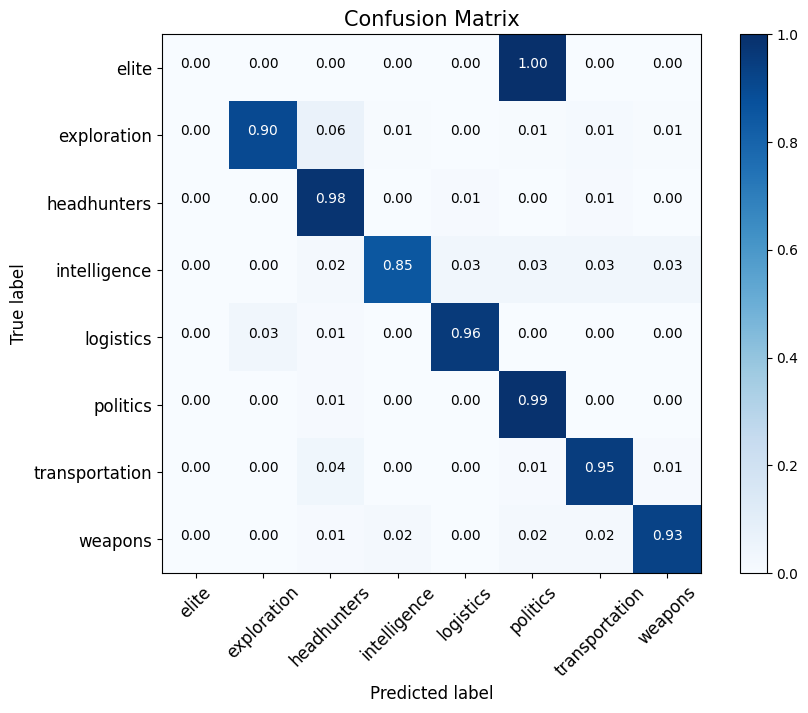

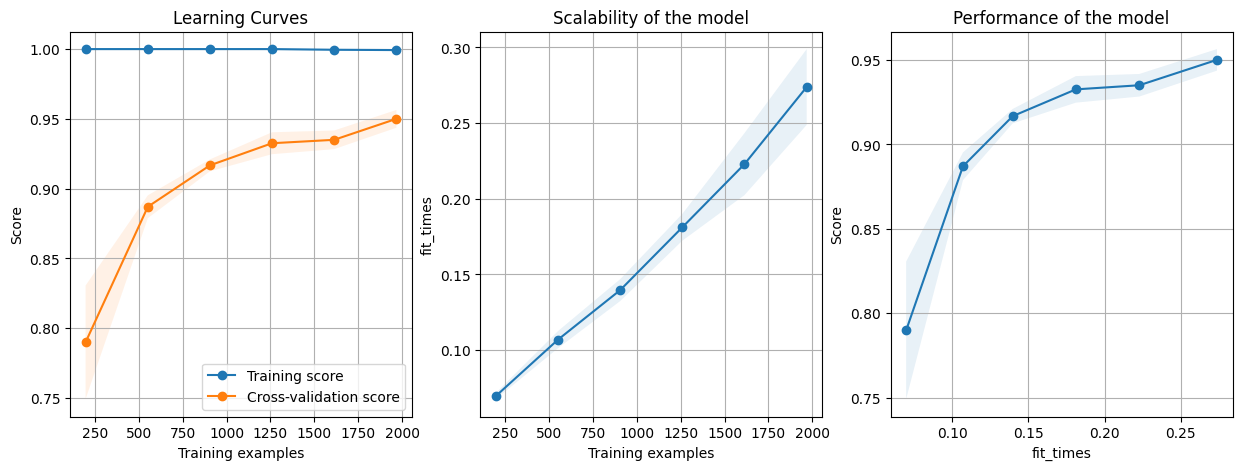

In [395]:
# Define the parameter grid
tfidf_grid={'max_features': [5000, 10000, 20000], 'min_df': [5, 10, 20], 'max_df': [0.5, 0.7, 1.0], 'ngram_range': [(1, 1), (1, 2)]}
best_vectorizer_new, X_train_tfidf_new, X_val_tfidf_new, best_params_new = tfidf_params(X_new_train_tfidf_params, X_new_val_tfidf_params, y_new_train_tfidf_params, y_new_val_tfidf_params, tfidf_grid)

model_grid = {'solver': ['liblinear', 'saga'], 'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}
best_model_new, best_params_logreg_new = train_logistic_regression(X_train_tfidf_new, y_new_train_tfidf_params, model_grid)

X_test_tfidf_new = best_vectorizer_new.transform(X_new_test_tfidf_params)
y_test_pred_new = best_model_new.predict(X_test_tfidf_new)
evaluate_model_new(X_train_tfidf_new, y_new_train_tfidf_params, y_new_test_tfidf_params, y_test_pred_new, best_model_new)

### Conclusions:

Calculating performance just for one record doesn't provide solid information.

It is essential to increase the size of both the training and test samples to achieve more meaningful and accurate results.

#### 8.1) Synthetic Data Generation

Create new records for the minority class using SMOTE vectorizing with TF-IDF and also with Embeddings

Split data into training and test as always for the rest of the classes. For the elite class we leace 5 records in the training sample, 3 in the test sample and 2 in the validation sample so there is real data in training, validation and testing.

In [396]:
# Separate elite class
elite_data = data_new_final[data_new_final['tag'] == 'elite']
non_elite_data = data_new_final[data_new_final['tag'] != 'elite']

# Split elite data: 5 for training, 2 for validation, 3 for testing
elite_train, elite_temp = train_test_split(elite_data, test_size=0.5, random_state=42)
elite_val, elite_test = train_test_split(elite_temp, test_size=3/5, random_state=42)

# Split non-elite data
X_non_elite, X_non_elite_test, y_non_elite, y_non_elite_test = train_test_split(non_elite_data['lemmatized'], non_elite_data['tag'], test_size=0.2, random_state=42)
X_non_elite_train, X_non_elite_val, y_non_elite_train, y_non_elite_val = train_test_split(X_non_elite, y_non_elite, test_size=0.2, random_state=42)

# Add elite data to splits
X_train_combined = pd.concat([X_non_elite_train, elite_train['lemmatized']])
y_train_combined = pd.concat([y_non_elite_train, elite_train['tag']])

X_val_combined = pd.concat([X_non_elite_val, elite_val['lemmatized']])
y_val_combined = pd.concat([y_non_elite_val, elite_val['tag']])

X_test_combined = pd.concat([X_non_elite_test, elite_test['lemmatized']])
y_test_combined = pd.concat([y_non_elite_test, elite_test['tag']])

##### 8.1.1) Using TF-IDF

A new function combines the Logistic Regression training with the SMOTE synthetic data generation to find the optimal number of Elite samples that needs to be created.

A combined approach is used to obtain both the best hyperparameters of the model combining also a different number of samples in the Elite class

In [397]:
tfidf_grid={'max_features': [5000, 10000, 20000], 'min_df': [5, 10, 20], 'max_df': [0.5, 0.7, 1.0], 'ngram_range': [(1, 1), (1, 2)]}
best_vectorizer_smote, X_train_tfidf_smote, X_val_tfidf_smote, best_params_smote = tfidf_params(X_train_combined, X_val_combined, y_train_combined, y_val_combined, tfidf_grid)

Best TF-IDF params: {'max_df': 0.7, 'max_features': 10000, 'min_df': 5, 'ngram_range': (1, 2)}
Best F1-Score: 0.9257585116866826


In [398]:
model_grid_sampled = {'solver': ['liblinear', 'saga'], 'C': [0.01, 1], 'penalty': ['l2'], 'class_weight': ['balanced'] }
smote_grid = {'sampling_strategy': [{'elite': 20},{'elite': 50},{'elite': 100},{'elite': 200}]}

In [399]:
best_model_smote, best_params_smote, X_train_resampled, y_train_resampled = train_logistic_regression_with_smote(X_train_tfidf_smote, y_train_combined, model_grid_sampled, smote_grid)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters (with SMOTE): {'logreg__C': 1, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l2', 'logreg__solver': 'saga', 'smote__sampling_strategy': {'elite': 20}}
Resampled Training Data Shape: (2473, 10000)
Resampled Training Labels Distribution: Counter({'headhunters': 388, 'politics': 382, 'transportation': 379, 'exploration': 376, 'weapons': 336, 'logistics': 306, 'intelligence': 286, 'elite': 20})


(accuracy, f1) are: (0.903896, 0.906946)

Classification Report:
                 precision    recall  f1-score   support

         elite       0.12      0.33      0.18         3
   exploration       0.95      0.91      0.93       140
   headhunters       0.80      0.94      0.86       107
  intelligence       0.91      0.86      0.89        95
     logistics       0.94      0.89      0.91        82
      politics       0.93      0.92      0.92       125
transportation       0.95      0.89      0.92       113
       weapons       0.93      0.90      0.92       105

      accuracy                           0.90       770
     macro avg       0.82      0.83      0.82       770
  weighted avg       0.91      0.90      0.91       770



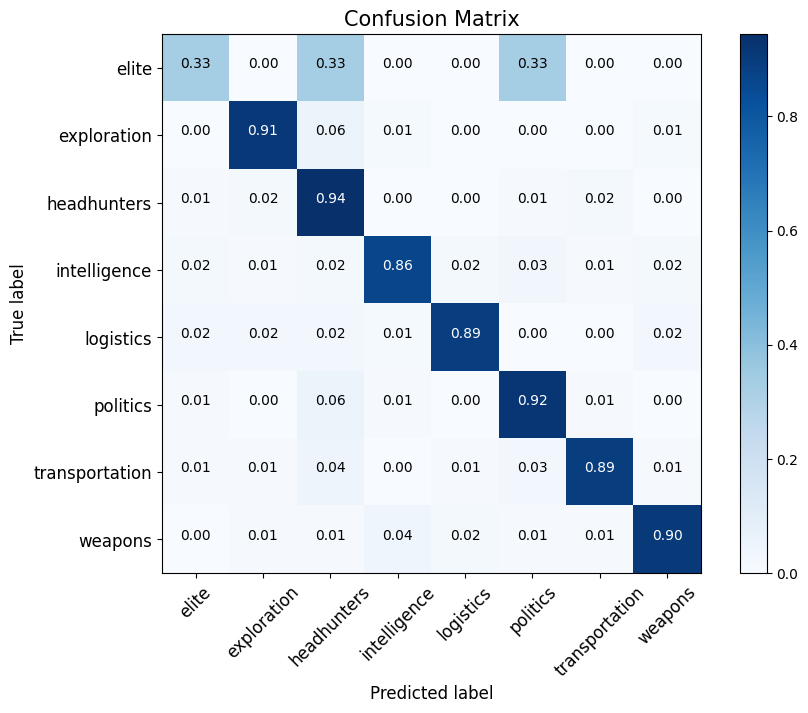

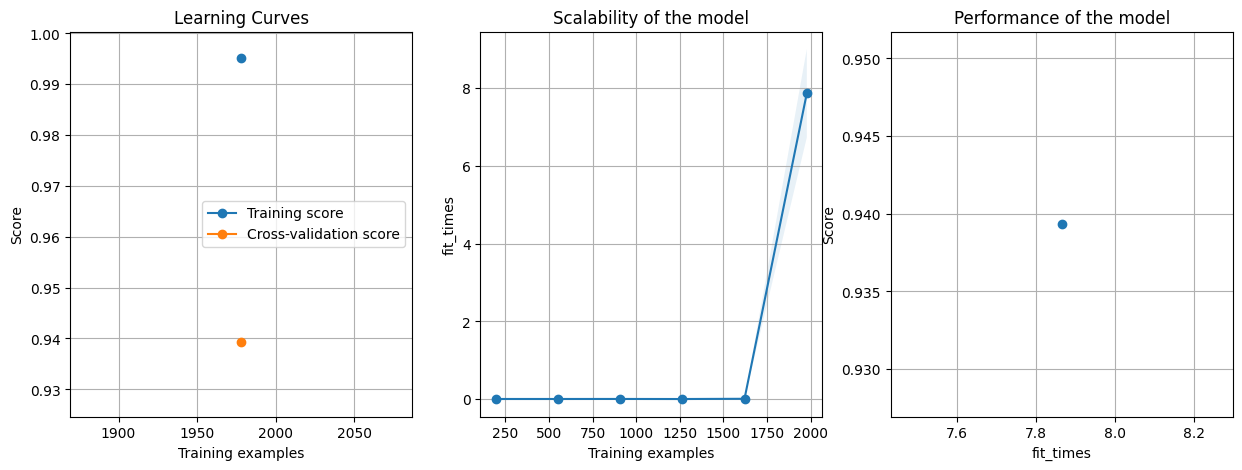

In [400]:
X_test_smote=best_vectorizer_smote.transform(X_test_combined)
y_test_pred_smote = best_model_smote.predict(X_test_smote)
evaluate_model_new(X_train_resampled, y_train_resampled, y_test_combined, y_test_pred_smote, best_model_smote)

Analysis of the synthetic data created. At first sight it looks similar to the input data, which is a good sign. 

Cosine similarity could be calculated to see how far it is from the real data or also an analysis by the stateholders to check if that can actually be also considered as good training data

In [401]:
# Identify synthetic samples
synthetic_indices = range(len(y_train_combined), len(y_train_resampled))
synthetic_samples = X_train_resampled[synthetic_indices]

# Decode synthetic samples back to text using TF-IDF vectorizer
synthetic_texts = []
feature_names = best_vectorizer_smote.get_feature_names_out() 

for sample in synthetic_samples[:5]:  
    non_zero_indices = sample.nonzero()[1]  
    words = [feature_names[i] for i in non_zero_indices] 
    synthetic_texts.append(" ".join(words))

# Display synthetic samples
print("\nSynthetic Data Samples:")
for i, text in enumerate(synthetic_texts):
    print(f"Synthetic Sample {i + 1}: {text}")


Synthetic Data Samples:
Synthetic Sample 1: pickup spill good news click shocked speculation bean havent heard uncle revealed guest fuller younger broken sequel creator confirmed finger medium played twin monday pair global happening perspective surprise guess sister role didnt even added silence evolution photo air shot concluded famous leaving full speak friend found didnt style far mary updated set news fan wondering ran saying im going told see whether said heard talk came best even actually day return going get would good house john call original today im whats havent keep go bob leonard cam neil johnny top ten reserved million dollar highest sixth top fifth fourth 205 wallet jesse simon jay 415 18 paid allowed howard phil row ten credit appear ed star rest tie series eric past took since although led yet television list world filled last year also mitchell announced show place four colleague million mark last first second time account year dollar made jim well
Synthetic Sample 2

##### 8.1.2) Using Embeddings

Predefine the number of synthetic samples that are going to be generated.

Combining with hyperparameter tuning provoques problems when running the learning curves fro example.

In [402]:
X_non_elite, X_non_elite_test, y_non_elite, y_non_elite_test = train_test_split(non_elite_data['cleaned_text'], non_elite_data['tag'], test_size=0.2, random_state=42)
X_non_elite_train, X_non_elite_val, y_non_elite_train, y_non_elite_val = train_test_split(X_non_elite, y_non_elite, test_size=0.2, random_state=42)

# Add elite data to splits
X_train_combined = pd.concat([X_non_elite_train, elite_train['cleaned_text']])
y_train_combined = pd.concat([y_non_elite_train, elite_train['tag']])

X_val_combined = pd.concat([X_non_elite_val, elite_val['cleaned_text']])
y_val_combined = pd.concat([y_non_elite_val, elite_val['tag']])

X_test_combined = pd.concat([X_non_elite_test, elite_test['cleaned_text']])
y_test_combined = pd.concat([y_non_elite_test, elite_test['tag']])

In [403]:
X_train_transformer_smote = get_transformer_embeddings(model_transformer, X_train_combined)
X_val_transformer_smote = get_transformer_embeddings(model_transformer, X_val_combined)
X_test_transformer_smote = get_transformer_embeddings(model_transformer, X_test_combined)

Batches: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


In [404]:
smote = SMOTE(sampling_strategy={'elite': 30}, random_state=42, k_neighbors=2)
X_train_resampled_transformer, y_train_resampled_transformer = smote.fit_resample(X_train_transformer_smote, y_train_combined)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Logistic Regression Params: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
(accuracy, f1) are: (0.900000, 0.900137)

Classification Report:
                 precision    recall  f1-score   support

         elite       1.00      0.67      0.80         3
   exploration       0.93      0.87      0.90       140
   headhunters       0.91      0.98      0.94       107
  intelligence       0.77      0.79      0.78        95
     logistics       0.84      0.90      0.87        82
      politics       0.98      0.95      0.96       125
transportation       0.95      0.92      0.93       113
       weapons       0.88      0.88      0.88       105

      accuracy                           0.90       770
     macro avg       0.91      0.87      0.88       770
  weighted avg       0.90      0.90      0.90       770



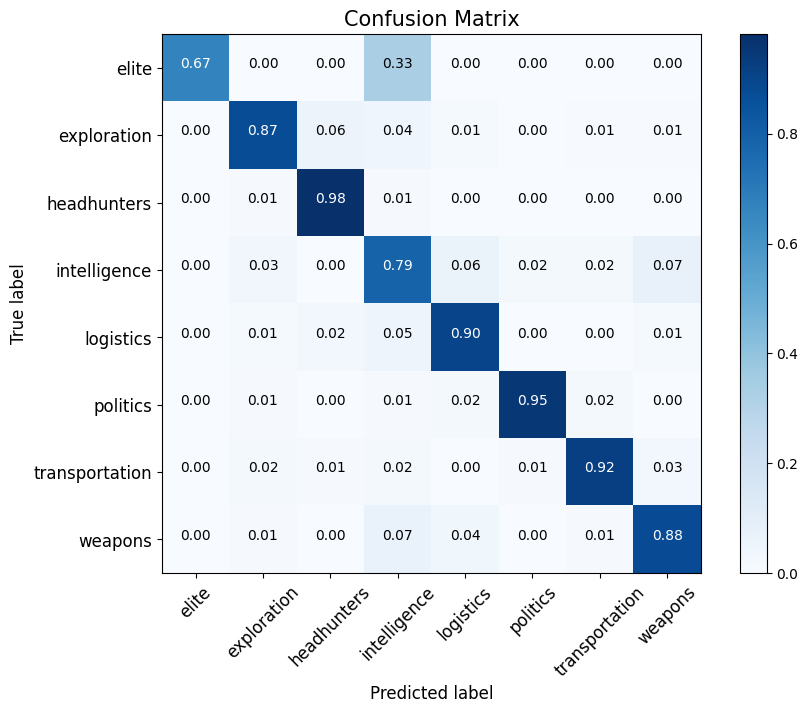

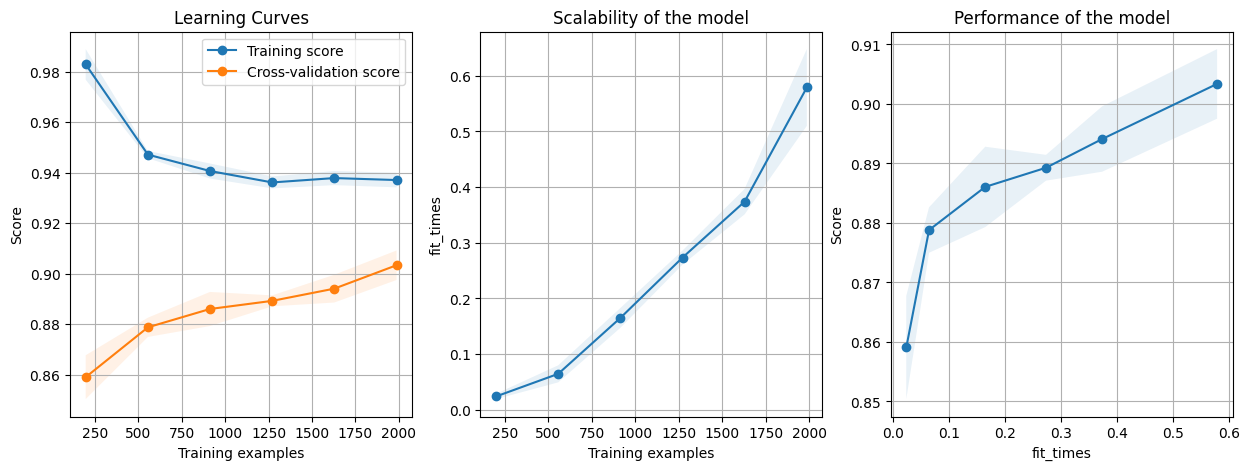

In [405]:
best_model_transformer_smote, best_params_logreg_transformer_smote = train_logistic_regression(X_train_resampled_transformer, y_train_resampled_transformer, model_grid_sampled)
y_test_pred_transformer_smote = best_model_transformer_smote.predict(X_test_transformer_smote)

evaluate_model_new(X_train_resampled_transformer, y_train_resampled_transformer, y_test_combined, y_test_pred_transformer_smote, best_model_transformer_smote)

After embeddings, text readable data can be obtained again but we see here the closest original text to some of the embedded sentences.

In [406]:
synthetic_indices = range(len(y_train_combined), len(y_train_resampled_transformer))
synthetic_samples = X_train_resampled_transformer[synthetic_indices]
synthetic_labels = y_train_resampled_transformer[synthetic_indices]

similarities = cosine_similarity(synthetic_samples, X_train_transformer_smote)
most_similar_indices = np.argmax(similarities, axis=1)

original_texts = X_train_combined.iloc[most_similar_indices].values
synthetic_text_data = [(synthetic, text) for synthetic, text in zip(synthetic_samples, original_texts)]

for i, (embedding, text) in enumerate(synthetic_text_data[:5]): 
    print(f"Synthetic Sample {i + 1}:")
    print(f"Closest Original Text: {text}")
    print(f"Synthetic Embedding: {embedding[:5]}...")  
    print()

Synthetic Sample 1:
Closest Original Text: sheldon cooper is again highest paid television actor jim parsons is the highest paid television actor in the world it is the fourth time in a row that the actor has been allowed to credit his account with 205 million dollars about 18 million euros in the past year its not the only actor who is doing well the first four places on the list are reserved for colleagues johnny galecki leonard on the show took second place with 193 million kunal nayyar raj and simon helberg howard tie for 182 million the rest of the list is filled by actors from the series ed o neil jay eric stonestreet cam jesse tyler ferguson mitchell and ty burrell phil all also appear to have well filled wallets yet they have to tolerate star mark harmon above them in fifth place although last year made it to the top ten the actor has now been ousted from his throne since his resignation from the top ten for actresses has not yet been announced but last year s led the list for 

In [407]:
np.mean(similarities)

np.float32(0.03498228)

### Conclusions:

Getting good results is a real challenge when only having 10 real values in our data.

Creating a small number of synthetic data improves significantly the performance. 

Using embeddings for vectorization gives better results when using SMOTE than just TF-IDF vectorization

The synthetic data generated doesn't have great similarity score compared with the original one as the text we are working with is very noisy and long.